In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Categorical.from_codes(wine.target, wine.target_names)

In [15]:
df = X.join(pd.Series(y, name='class'))
print(X.shape, y.shape)
df.head()

(178, 13) (178,)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0


# LDA

1. Compute the within class and between class scatter matrices
2. Compute the eigenvectors and corresponding eigenvalues for the scatter matrices
3. Sort the eigenvalues and select the top k
4. Create a new matrix containing eigenvectors that map to the k eigenvalues
5. Obtain the new features (i.e. LDA components) by taking the cross product of the data and the matrix from step 4

## 1. Compute the within class and between class scatter matrices

### Within class matrix

Scatter within each class.

$ S_w = \sum_{i=1}^{C} {S_i} $ , where `c`: is the total no of classes

$ S_i = \sum_{x=1}^{m} {(x-u_i)(x-u_i)'} $, $ S_i $ is the scatter for that class

In [17]:
class_feature_means = pd.DataFrame(columns=wine.target_names)
for c, rows in df.groupby('class'):
    class_feature_means[c] = rows.mean()
class_feature_means

,class_0,class_1,class_2
alcohol,13.744746,12.278732,13.153750
malic_acid,2.010678,1.932676,3.333750
ash,2.455593,2.244789,2.437083
alcalinity_of_ash,17.037288,20.238028,21.416667
magnesium,106.338983,94.549296,99.312500
total_phenols,2.840169,2.258873,1.678750
flavanoids,2.982373,2.080845,0.781458
nonflavanoid_phenols,0.290000,0.363662,0.447500
proanthocyanins,1.899322,1.630282,1.153542
color_intensity,5.528305,3.086620,7.396250


In [58]:
m, n = X.shape
within_class_matrix = np.zeros((n, n))

for c, rows in df.groupby('class'):
    rows = rows.drop(['class'], axis=1)
    s = np.zeros((n, n))
    for i, row in rows.iterrows():
        mean = class_feature_means[c].values.reshape(-1, 1)
        x = row.values.reshape(-1, 1)
        s += (x-mean) @ ((x-mean).T)
    within_class_matrix += s

### Between Class Scatter Matrix

\begin{equation}
S_B = \sum_{i=1}^c {N_i * (m_i - m) * (m_i - m).T}
\end{equation}

$ N_i $: No of samples in a class

$ m_i $: class variance

`m`: mean of all features

In [66]:
between_class_matrix = np.zeros((n,n))
features_mean = df.mean()

for c in class_feature_means:
    n_i = len(df[df['class'] == c])
    m_i = class_feature_means[c].values.reshape(-1, 1)
    m = features_mean.values.reshape(-1, 1)
    between_class_matrix += n_i * (m_i - m) @ (m_i - m).T

### Make linear discriminant by finding eigen values for this equation

\begin{equation}
S_w^{-1} * S_B
\end{equation}

In [69]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_matrix).dot(between_class_matrix))

In [73]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])

9.08173943504247
4.128469045639485
8.757468096729126e-16
6.997096258273158e-16
6.567555883195076e-16
6.567555883195076e-16
2.9002924633706455e-16
2.447634471068126e-16
2.447634471068126e-16
2.1950033409800432e-16
4.134903483865132e-17
3.950057054838905e-17
0.0


In [75]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Explained Variance
Eigenvector 0: 0.6874788878860782
Eigenvector 1: 0.3125211121139217
Eigenvector 2: 6.629318613355477e-17
Eigenvector 3: 5.2967341647222384e-17
Eigenvector 4: 4.971576256952484e-17
Eigenvector 5: 4.971576256952484e-17
Eigenvector 6: 2.1954933320029802e-17
Eigenvector 7: 1.8528356116767136e-17
Eigenvector 8: 1.8528356116767136e-17
Eigenvector 9: 1.6615962906186698e-17
Eigenvector 10: 3.1300819286174307e-18
Eigenvector 11: 2.9901549703892255e-18
Eigenvector 12: 0.0


In [76]:
w_matrix = np.hstack((pairs[0][1].reshape(13,1), pairs[1][1].reshape(13,1))).real

In [78]:
X_lda = np.array(X.dot(w_matrix))

In [82]:
X_lda_df = pd.DataFrame(X_lda, columns=['lda1', 'lda2'])
X_lda_df['class'] = df['class']

# Plot the Lda

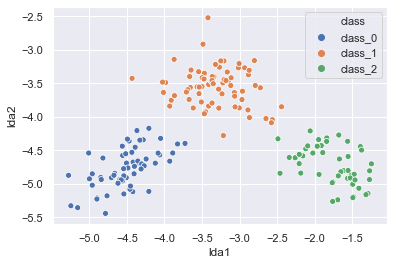

In [83]:
sns.scatterplot(x='lda1', y='lda2', hue='class', data=X_lda_df)

# PCA

In [112]:
X_val = X.values
mean, std = X_val.mean(axis=0), X_val.std(axis=0)
X_val = (X_val - mean) / (2*std)
cov_mat = X_val.T @ X_val
U, S, V = np.linalg.svd(cov_mat)
U_red = U[:, :2]
Z = X_val @ U_red
X_pca_df = pd.DataFrame(Z, columns=['pca1', 'pca2'])
X_pca_df['class'] = df['class']

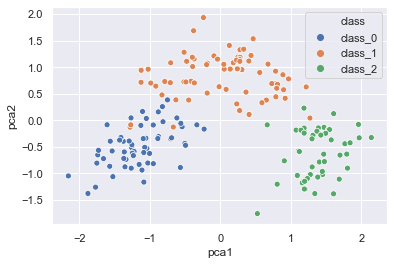

In [113]:
sns.scatterplot(x='pca1', y='pca2', hue='class', data=X_pca_df)

As you can see there is a clear difference here! LDA Separates the classes well whereas PCA doesnot. Well, PCA was never meant to do this.

> PCA is reducing dimensions by minimising the projection error or maximising the scatter

> whereas, LDA is reducing dimensions by minimizing `interclass variance`($S_W$) and maximizing `intraclass variance`($S_B$)